## Imports

In [28]:
import vtk
import numpy

---

## Helper-functions

We're gonna use this function to embed a still image of a VTK render

In [29]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Update()
    writer.Write()
    data = writer.GetResult()
    
    return Image(data)

This function adds a line to a `vtkRenderer`

In [30]:
def addLine(renderer, p1, p2, color=[0.0, 0.0, 1.0], opacity=1.0):
    line = vtk.vtkLineSource()
    line.SetPoint1(p1)
    line.SetPoint2(p2)

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(line.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(color)
    actor.GetProperty().SetOpacity(opacity)
    actor.GetProperty()

    renderer.AddActor(actor)

This function adds a point (a sphere really) to a `vtkRenderer`

In [31]:
def addPoint(renderer, p, color=[0.0, 0.0, 0.0], radius=0.5):
    point = vtk.vtkSphereSource()
    point.SetCenter(p)
    point.SetRadius(radius)
    point.SetPhiResolution(100)
    point.SetThetaResolution(100)

    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(point.GetOutputPort())

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(color)

    renderer.AddActor(actor)

Quick conversion between a `numpy.ndarray` and a `list`

In [32]:
l2n = lambda l: numpy.array(l)
n2l = lambda n: list(n)

---

## Options

Environment options

In [33]:
# SUN OPTIONS
# Radius of the sun half-sphere
RadiusSun = 10.0
# Distance of sun's center from (0,0,0)
DistanceSun = 50.0
# Phi & Theta Resolution of sun
ResolutionSun = 6

# EARTH OPTIONS
# Radius of the earth sphere
RadiusEarth = 150.0
# Phi & Theta Resolution of earth
ResolutionEarth = 120

# RAY OPTIONS
# Length of rays cast from the sun. Since the rays we
# cast are finite lines we set a length appropriate to the scene.
# CAUTION: If your rays are too short they won't hit the earth 
# and ray-tracing won't be possible. Its better for the rays to be
# longer than necessary than the other way around
RayCastLength = 500.0

# COLOR OPTIONS
# Color of the sun half-sphere's surface
ColorSun = [1.0, 1.0, 0.0]
# Color of the sun half-sphere's edges
ColorSunEdge = [0.0, 0.0, 0.0]
# Color of the earth sphere's edges
ColorEarthEdge = [1.0, 1.0, 1.0]
# Background color of the scene
ColorBackground = [0.0, 0.0, 0.0]
# Ambient color light 
ColorLight = [1.0, 1.0, 0.0]
# Color of the sun's cell-center points
ColorSunPoints = [1.0, 1.0, 0.0]
# Color of the sun's cell-center normal-vector glyphs
ColorSunGlyphs = [1.0, 1.0, 0.0]
# Color of sun rays that intersect with earth
ColorRayHit = [1.0, 1.0, 0.0]
# Color of sun rays that miss the earth
ColorRayMiss = [1.0, 1.0, 1.0]
# Opacity of sun rays that miss the earth
OpacityRayMiss = 0.5
# Color of rays showing the normals from points on earth hit by sun rays
ColorEarthGlyphs = [0.0, 0.0, 1.0]
# Color of sun rays bouncing off earth 
ColorRayReflected = [1.0, 1.0, 0.0]

---

## 'Environment' Creation

### Create the `sun`

In [34]:
# Create and configure then sun half-sphere
sun = vtk.vtkSphereSource()
sun.SetCenter(0.0, DistanceSun, 0.0)
sun.SetRadius(RadiusSun)
sun.SetThetaResolution(ResolutionSun)
sun.SetPhiResolution(ResolutionSun)
sun.SetStartTheta(180)  # create a half-sphere

# Create mapper
mapperSun = vtk.vtkPolyDataMapper()
mapperSun.SetInputData(sun.GetOutput())

# Create actor
actorSun = vtk.vtkActor()
actorSun.SetMapper(mapperSun)
actorSun.GetProperty().SetColor(ColorSun)  #set color to yellow
actorSun.GetProperty().EdgeVisibilityOn()  # show edges/wireframe
actorSun.GetProperty().SetEdgeColor(ColorSunEdge)  #render edges as white

Create a new `vtkRenderer` and visualize the scene using `vtk_show`

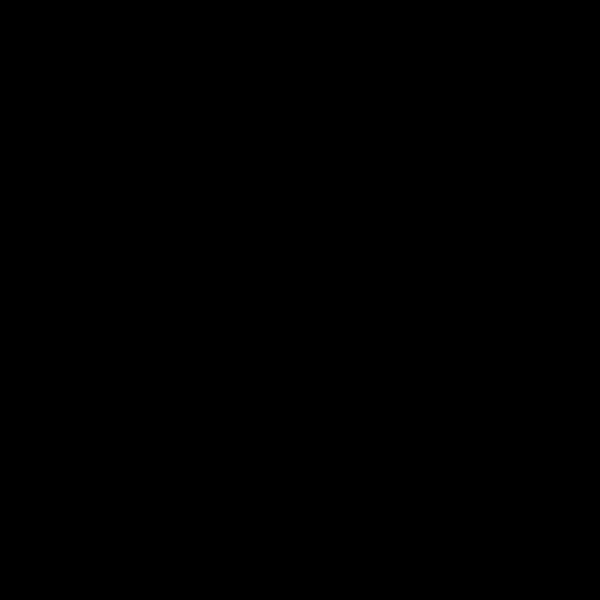

In [35]:
renderer = vtk.vtkRenderer()
renderer.AddActor(actorSun)
renderer.SetBackground(ColorBackground)

# Modify the camera with properties defined manually in Paraview
camera = renderer.MakeCamera()
camera.SetPosition(RadiusEarth, DistanceSun, RadiusEarth)
camera.SetFocalPoint(0.0, 0.0, 0.0)
camera.SetViewAngle(30.0)
renderer.SetActiveCamera(camera)

vtk_show(renderer, 600, 600)

### Create the `earth`

Create `earth` sphere with a texture, which can be downloaded at [http://planetpixelemporium.com/download/download.php?earthmap1k.jpg](http://planetpixelemporium.com/download/download.php?earthmap1k.jpg)

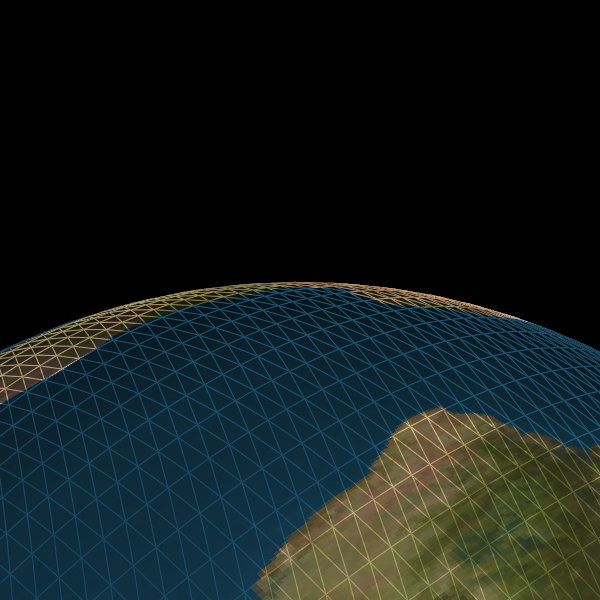

In [36]:
# Create and configure the earth sphere
earth = vtk.vtkSphereSource()
earth.SetCenter(0.0, -RadiusEarth, 0.0)
earth.SetThetaResolution(ResolutionEarth)
earth.SetPhiResolution(ResolutionEarth)
earth.SetRadius(RadiusEarth)

# Load a JPEG file with an 'earth' texture downloaded from the above link
reader = vtk.vtkJPEGReader()
reader.SetFileName("earthmap1k.jpg")
reader.Update()

# Create a new 'vtkTexture' and set the loaded JPEG
texture = vtk.vtkTexture()
texture.SetInputConnection(reader.GetOutputPort())
texture.Update()

# Map the earth texture to the earth sphere
map_to_sphere = vtk.vtkTextureMapToSphere()
map_to_sphere.SetInputConnection(earth.GetOutputPort())
map_to_sphere.PreventSeamOn()
map_to_sphere.Update()

# Create a new mapper with the mapped texture and sphere
mapperEarth = vtk.vtkPolyDataMapper()
mapperEarth.SetInputConnection(map_to_sphere.GetOutputPort())

# Create actor
actorEarth = vtk.vtkActor()
actorEarth.SetMapper(mapperEarth)
actorEarth.SetTexture(texture)
actorEarth.GetProperty().EdgeVisibilityOn()  # show edges/wireframe
actorEarth.GetProperty().SetEdgeColor(ColorEarthEdge)  #render edges as white

renderer.AddActor(actorEarth)
vtk_show(renderer, 600, 600)

### Adding lighting to the scene

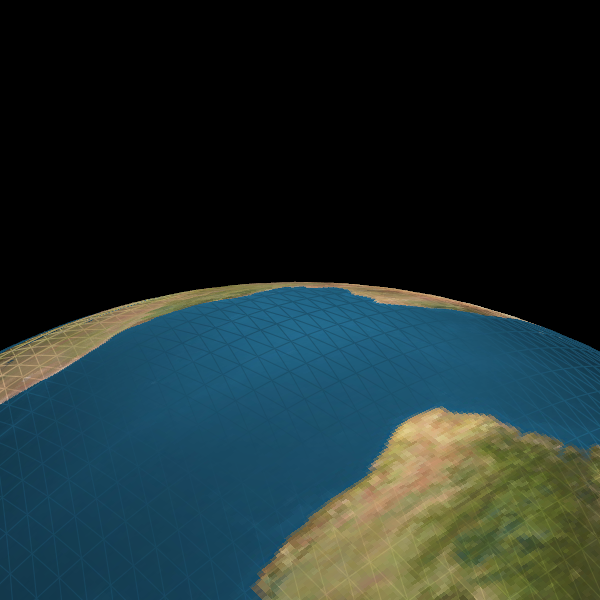

In [37]:
# Create a new vtkLight
light = vtk.vtkLight()
# Set its ambient color to yellow
light.SetAmbientColor(ColorLight)
# Set a 180 degree cone angle to avoid a spotlight-effect
light.SetConeAngle(180)
# Set its position to the sun's center
light.SetPosition(sun.GetCenter())
# Set its focal-point to the earth's center 
light.SetFocalPoint(earth.GetCenter())
# Set it as part of the scene (positional) and not following the camera
light.SetPositional(True)
renderer.AddLight(light)

vtk_show(renderer, 600, 600)

---

## 'Prepare' the Sun Rays

### Calculate the cell-centers of the sun half-sphere

In [38]:
cellCenterCalcSun = vtk.vtkCellCenters()
cellCenterCalcSun.SetInputData(sun.GetOutput())
cellCenterCalcSun.Update()

Visualize all cell-centers with points

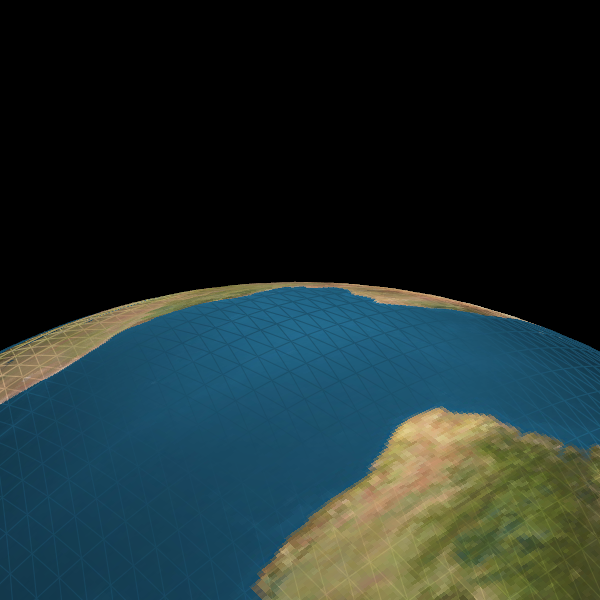

In [39]:
# Get the point centers from 'cellCenterCalc'
pointsCellCentersSun = cellCenterCalcSun.GetOutput(0)

# Loop through all point centers and add a point-actor through 'addPoint'
for idx in range(pointsCellCentersSun.GetNumberOfPoints()):
    addPoint(renderer, pointsCellCentersSun.GetPoint(idx), ColorSunPoints)

vtk_show(renderer, 600, 600)

### Calculate normal vectors at the center of each cell

In [40]:
# Create a new 'vtkPolyDataNormals' and connect to the 'sun' half-sphere
normalsCalcSun = vtk.vtkPolyDataNormals()
normalsCalcSun.SetInputConnection(sun.GetOutputPort())

# Disable normal calculation at cell vertices
normalsCalcSun.ComputePointNormalsOff()
# Enable normal calculation at cell centers
normalsCalcSun.ComputeCellNormalsOn()
# Disable splitting of sharp edges
normalsCalcSun.SplittingOff()
# Disable global flipping of normal orientation
normalsCalcSun.FlipNormalsOff()
# Enable automatic determination of correct normal orientation
normalsCalcSun.AutoOrientNormalsOn()
# Perform calculation
normalsCalcSun.Update()

### Visualize normal vectors at the cell-centers of sun's surface as glyphs

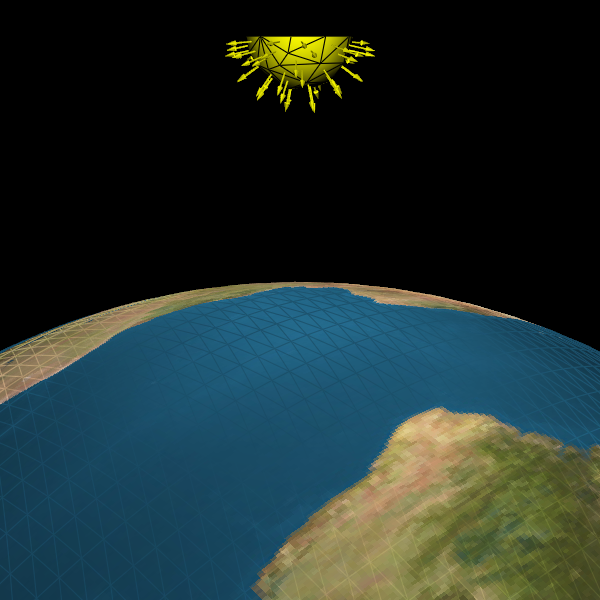

In [41]:
# Create a 'dummy' 'vtkCellCenters' to force the glyphs to the cell-centers
dummy_cellCenterCalcSun = vtk.vtkCellCenters()
dummy_cellCenterCalcSun.VertexCellsOn()
dummy_cellCenterCalcSun.SetInputConnection(normalsCalcSun.GetOutputPort())

# Create a new 'default' arrow to use as a glyph
arrow = vtk.vtkArrowSource()

# Create a new 'vtkGlyph3D'
glyphSun = vtk.vtkGlyph3D()
# Set its 'input' as the cell-center normals calculated at the sun's cells
glyphSun.SetInputConnection(dummy_cellCenterCalcSun.GetOutputPort())
# Set its 'source', i.e., the glyph object, as the 'arrow'
glyphSun.SetSourceConnection(arrow.GetOutputPort())
# Enforce usage of normals for orientation
glyphSun.SetVectorModeToUseNormal()
# Set scale for the arrow object
glyphSun.SetScaleFactor(5)

# Create a mapper for all the arrow-glyphs
glyphMapperSun = vtk.vtkPolyDataMapper()
glyphMapperSun.SetInputConnection(glyphSun.GetOutputPort())

# Create an actor for the arrow-glyphs
glyphActorSun = vtk.vtkActor()
glyphActorSun.SetMapper(glyphMapperSun)
glyphActorSun.GetProperty().SetColor(ColorSunGlyphs)
# Add actor
renderer.AddActor(glyphActorSun)

vtk_show(renderer, 600, 600)

---

## Prepare for ray-tracing

Create `vtkOBBTree` to test intersections with `earth`

In [42]:
obbEarth = vtk.vtkOBBTree()
obbEarth.SetDataSet(earth.GetOutput())
obbEarth.BuildLocator()

Calculate earth's normals

In [43]:
# Create a new 'vtkPolyDataNormals' and connect to the 'earth' sphere
normalsCalcEarth = vtk.vtkPolyDataNormals()
normalsCalcEarth.SetInputConnection(earth.GetOutputPort())

# Disable normal calculation at cell vertices
normalsCalcEarth.ComputePointNormalsOff()
# Enable normal calculation at cell centers
normalsCalcEarth.ComputeCellNormalsOn()
# Disable splitting of sharp edges
normalsCalcEarth.SplittingOff()
# Disable global flipping of normal orientation
normalsCalcEarth.FlipNormalsOff()
# Enable automatic determination of correct normal orientation
normalsCalcEarth.AutoOrientNormalsOn()
# Perform calculation
normalsCalcEarth.Update()

Define intersection helper-functions

In [50]:
def isHit(obbTree, pSource, pTarget):
    r"""Returns True if the line intersects with the mesh in 'obbTree'"""
    code = obbTree.IntersectWithLine(pSource, pTarget, None, None)
    if code==0:
        return False
    return True

def GetIntersect(obbTree, pSource, pTarget):
    
    # Create an empty 'vtkPoints' object to store the intersection point coordinates
    points = vtk.vtkPoints()
    # Create an empty 'vtkIdList' object to store the ids of the cells that intersect
    # with the cast rays
    cellIds = vtk.vtkIdList()
    
    # Perform intersection
    code = obbTree.IntersectWithLine(pSource, pTarget, points, cellIds)
    
    # Get point-data 
    pointData = points.GetData()
    # Get number of intersection points found
    noPoints = pointData.GetNumberOfTuples()
    # Get number of intersected cell ids
    noIds = cellIds.GetNumberOfIds()
    
    assert (noPoints == noIds)
    print(noPointd)
    # Loop through the found points and cells and store
    # them in lists
    pointsInter = []
    cellIdsInter = []
    for idx in range(noPoints):
        pointsInter.append(pointData.GetTuple3(idx))
        cellIdsInter.append(cellIds.GetId(idx))
    
    return pointsInter, cellIdsInter

## Perform ray-casting operations and visualize different aspects

### Cast rays, test for intersections, and visualize the rays that hit `earth`

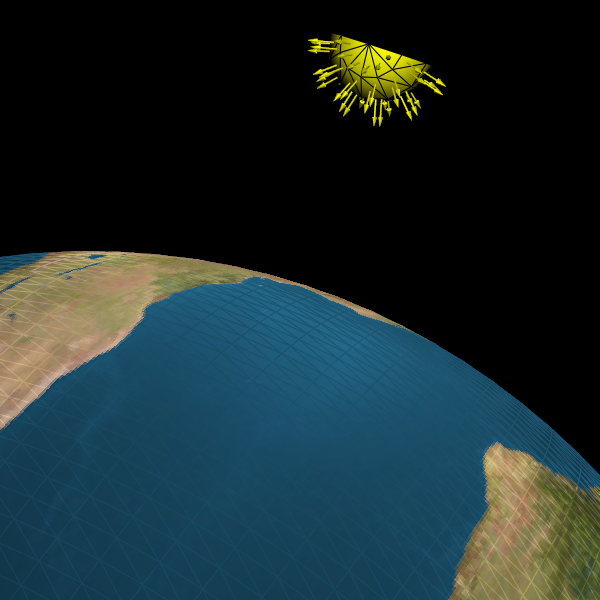

In [51]:
# Extract the normal-vector data at the sun's cells
normalsSun = normalsCalcSun.GetOutput().GetCellData().GetNormals()

# Loop through all of sun's cell-centers
for idx in range(pointsCellCentersSun.GetNumberOfPoints()):
    # Get coordinates of sun's cell center
    pointSun = pointsCellCentersSun.GetPoint(idx)
    # Get normal vector at that cell
    normalSun = normalsSun.GetTuple(idx)
    
    # Calculate the 'target' of the ray based on 'RayCastLength'
    pointRayTarget = n2l(l2n(pointSun) + RayCastLength*l2n(normalSun))
    
    # Check if there are any intersections for the given ray
    if isHit(obbEarth, pointSun, pointRayTarget):  # intersections were found
        # Retrieve coordinates of intersection points and intersected cell ids
        pointsInter, cellIdsInter = GetIntersect(obbEarth, pointSun, pointRayTarget)
        # Render lines/rays emanating from the sun. Rays that intersect are
        # rendered with a 'ColorRayHit' color
        addLine(renderer, pointSun, pointsInter[0], ColorRayHit)
        # Render intersection points
        addPoint(renderer, pointsInter[0], ColorRayHit)
    else:
        # Rays that miss the earth are rendered with a 'ColorRayMiss' colors
        # and a 25% opacity
        addLine(renderer, pointSun, pointRayTarget, ColorRayMiss, opacity=0.25)
        
vtk_show(renderer, 600, 600)

### Visualize the normal vectors at the cells where sun's rays intersect with earth

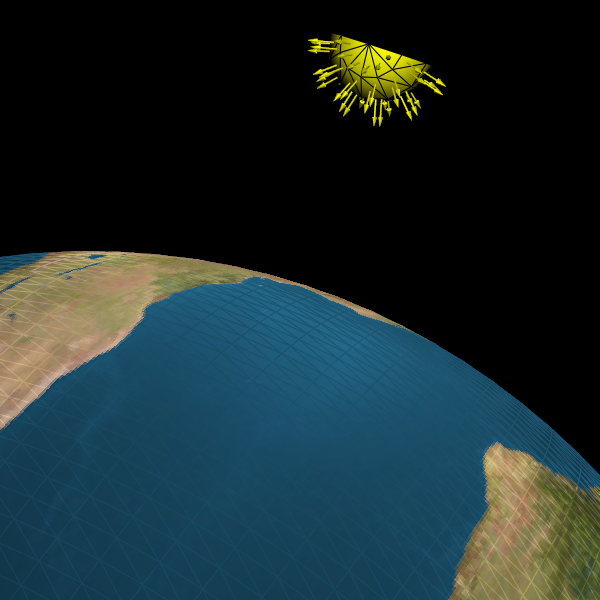

In [52]:
# Extract the normal-vector data at the sun's cells
normalsSun = normalsCalcSun.GetOutput().GetCellData().GetNormals()
# Extract the normal-vector data at the earth's cells
normalsEarth = normalsCalcEarth.GetOutput().GetCellData().GetNormals()

# Create a dummy 'vtkPoints' to act as a container for the point coordinates
# where intersections are found
dummy_points = vtk.vtkPoints()
# Create a dummy 'vtkDoubleArray' to act as a container for the normal
# vectors where intersections are found
dummy_vectors = vtk.vtkDoubleArray()
dummy_vectors.SetNumberOfComponents(3)
# Create a dummy 'vtkPolyData' to store points and normals
dummy_polydata = vtk.vtkPolyData()

# Loop through all of sun's cell-centers
for idx in range(pointsCellCentersSun.GetNumberOfPoints()):
    # Get coordinates of sun's cell center
    pointSun = pointsCellCentersSun.GetPoint(idx)
    # Get normal vector at that cell
    normalSun = normalsSun.GetTuple(idx)

    # Calculate the 'target' of the ray based on 'RayCastLength'
    pointRayTarget = n2l(l2n(pointSun) + RayCastLength*l2n(normalSun))
    
    # Check if there are any intersections for the given ray
    if isHit(obbEarth, pointSun, pointRayTarget):
        # Retrieve coordinates of intersection points and intersected cell ids
        pointsInter, cellIdsInter = GetIntersect(obbEarth, pointSun, pointRayTarget)
        # Get the normal vector at the earth cell that intersected with the ray
        normalEarth = normalsEarth.GetTuple(cellIdsInter[0])
        
        # Insert the coordinates of the intersection point in the dummy container
        dummy_points.InsertNextPoint(pointsInter[0])
        # Insert the normal vector of the intersection cell in the dummy container
        dummy_vectors.InsertNextTuple(normalEarth)

# Assign the dummy points to the dummy polydata
dummy_polydata.SetPoints(dummy_points)
# Assign the dummy vectors to the dummy polydata
dummy_polydata.GetPointData().SetNormals(dummy_vectors)
   
# Visualize normals as done previously but using 
# the 'dummyPolyData'
arrow = vtk.vtkArrowSource()

glyphEarth = vtk.vtkGlyph3D()
glyphEarth.SetInputData(dummy_polydata)
glyphEarth.SetSourceConnection(arrow.GetOutputPort())
glyphEarth.SetVectorModeToUseNormal()
glyphEarth.SetScaleFactor(5)

glyphMapperEarth = vtk.vtkPolyDataMapper()
glyphMapperEarth.SetInputConnection(glyphEarth.GetOutputPort())

glyphActorEarth = vtk.vtkActor()
glyphActorEarth.SetMapper(glyphMapperEarth)
glyphActorEarth.GetProperty().SetColor(ColorEarthGlyphs)

renderer.AddActor(glyphActorEarth)

vtk_show(renderer, 600, 600)

### Calculate and visualize reflected rays

Helper-function to calculate the reflected ray vector from an incident and normal vectors

In [53]:
def calcVecR(vecInc, vecNor):
    vecInc = l2n(vecInc)
    vecNor = l2n(vecNor)
    
    vecRef = vecInc - 2*numpy.dot(vecInc, vecNor)*vecNor
    
    return n2l(vecRef)

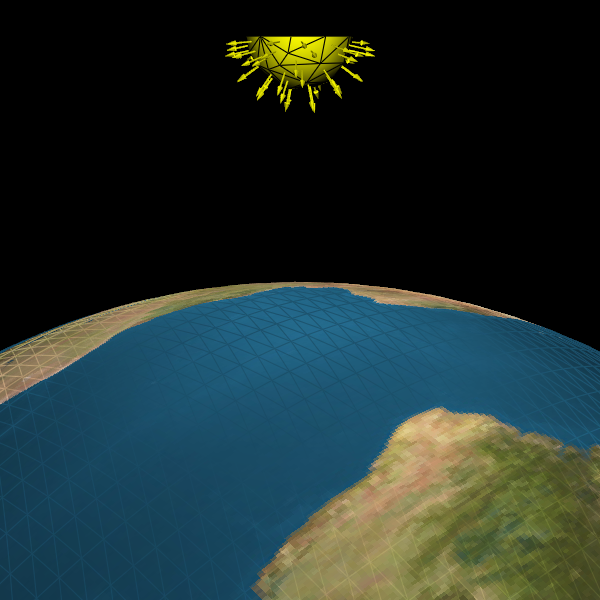

In [48]:
# Extract the normal-vector data at the sun's cells
normalsSun = normalsCalcSun.GetOutput().GetCellData().GetNormals()
# Extract the normal-vector data at the earth's cells
normalsEarth = normalsCalcEarth.GetOutput().GetCellData().GetNormals()

# Loop through all of sun's cell-centers
for idx in range(pointsCellCentersSun.GetNumberOfPoints()):
    # Get coordinates of sun's cell center
    pointSun = pointsCellCentersSun.GetPoint(idx)
    # Get normal vector at that cell
    normalSun = normalsSun.GetTuple(idx)
    
    # Calculate the 'target' of the ray based on 'RayCastLength'
    pointRayTarget = n2l(l2n(pointSun) + RayCastLength*l2n(normalSun))
    
    # Check if there are any intersections for the given ray
    if isHit(obbEarth, pointSun, pointRayTarget):
        # Retrieve coordinates of intersection points and intersected cell ids
        pointsInter, cellIdsInter = GetIntersect(obbEarth, pointSun, pointRayTarget)
        # Get the normal vector at the earth cell that intersected with the ray
        normalEarth = normalsEarth.GetTuple(cellIdsInter[0])
        
        # Calculate the incident ray vector
        vecInc = n2l(l2n(pointRayTarget) - l2n(pointSun))
        # Calculate the reflected ray vector
        vecRef = calcVecR(vecInc, normalEarth)
        
        # Calculate the 'target' of the reflected ray based on 'RayCastLength'
        pointRayReflectedTarget = n2l(l2n(pointsInter[0]) + RayCastLength*l2n(vecRef))

        # Render lines/rays bouncing off earth with a 'ColorRayReflected' color
        addLine(renderer, pointsInter[0], pointRayReflectedTarget, ColorRayReflected)
        
vtk_show(renderer, 600, 600)

In [49]:
# Uncomment and run this code to create a new window
# with an interactive view of the scene

renWin = vtk.vtkRenderWindow()
renWin.AddRenderer(renderer)
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
renWin.SetSize(600, 600)

iren.Initialize()
renWin.Render()
iren.Start()